In [1]:
from collections import OrderedDict
from copy import deepcopy
import os
from typing import Optional, Tuple, Union

import torch
import torch.backends.cuda
import torch.backends.cudnn
from jsonargparse import lazy_instance
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.cli import LightningCLI
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from torchmetrics import Accuracy
from tqdm import tqdm
import sys
sys.path.append('/homes/frinaldi/Merge2Update')
from permutations.permutation_spec import ViT_B_PermutationSpecBuilder
from permutations.weights_matching import weight_matching, LayerIterationOrder
from permutations.utils import apply_permutation_to_statedict 
from src_.data import DataModule
from src_.model import ClassificationModel
from pytorch_lightning import seed_everything
from torchvision.transforms import v2
from torchvision.datasets import CIFAR10
from torch import nn
import numpy as np 
import types
from scipy.optimize import linear_sum_assignment

def evaluate_vit(dataloader, model):
    eval_avg_loss = 0
    all_probs = []
    all_targets = []
    ce_loss = nn.CrossEntropyLoss()
    accuracy = Accuracy(task='multiclass', num_classes=10).to(device)
    model.eval()
    for batch in tqdm(dataloader):
        images, targets = batch
        images = images.to(device)
        targets =  targets.to(device)
        with torch.no_grad():
            outputs = model(images)
            probs = torch.softmax(outputs, dim=-1)
            all_probs.append(probs.cpu())
            all_targets.append(targets.cpu())
            loss = ce_loss(outputs, targets)
        
            eval_avg_loss += loss.item()  
    all_probs = torch.cat(all_probs, axis=0)
    all_targets = torch.cat(all_targets, axis=0)
    eval_avg_loss /= len(dataloader)  
    acc = accuracy(all_probs, all_targets)
    return acc, eval_avg_loss

def loss_barrier(model_a, model_b, dataloader, alphas=np.linspace(0, 1, 5)):
    """
    Evaluate and plot the loss barrier between model_a and model_b.
    
    Parameters:
        model_a: The first model.
        model_b: The second model.
        dataloader: Dataloader for evaluation.
        alphas: Array of interpolation coefficients to evaluate.

    Returns:
        losses: List of losses for the interpolated models.
    """
    # Prepare a deepcopy of model_a to hold the interpolated weights
    model_c = deepcopy(model_a)
    model_c = model_c.to(device)

    # Extract the state dictionaries
    theta_a = model_a.net.state_dict()
    theta_b = model_b.net.state_dict()

    losses = []
    accs = []
    for alpha in tqdm(alphas, desc="Evaluating Loss Barrier"):
        # Interpolate weights
        theta_c = interpolate(theta_a, theta_b, alpha)
        model_c.net.load_state_dict(theta_c)

        # Evaluate interpolated model
        acc, loss = evaluate_vit(dataloader, model_c)
        losses.append(loss)
        accs.append(acc.cpu().numpy())

    return alphas, accs, losses
def interpolate(theta_a: OrderedDict, theta_b: OrderedDict, alpha = 0.5) -> OrderedDict:
    assert set(theta_a.keys()) == set(theta_b.keys())
    theta = {}
    for key in theta_a.keys():
        if 'identity' in key:
            sim_mat = (1-alpha) * theta_a[key] + alpha * theta_b[key]
            # sim_mat_normalized = sinkhorn_normalization(sim_mat)
            row_ind, col_ind = linear_sum_assignment(sim_mat.cpu().numpy(), maximize=True)
            I3 = torch.zeros_like(sim_mat).to(device)
            I3[row_ind, col_ind] = 1
            theta[key] = I3
            # Compute the Frobenius norm
            # frobenius_norm = torch.norm(I3 - sim_mat, p='fro')**2
            # print(f"Frobenius norm ||I3 - [(1-alpha)I1 + alphaI2] |_F^2: {frobenius_norm.item()}")
            
        else:
            theta[key] = (1-alpha) * theta_a[key] + alpha * theta_b[key]

    return theta
def my_forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
    
    self_attention_outputs = self.attention(
            self.layernorm_before(hidden_states),  # in ViT, layernorm is applied before self-attention
            head_mask,
            output_attentions=output_attentions,
        )
    attention_output = self_attention_outputs[0]
    outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

    # first residual connection
    hidden_states = attention_output + self.attention.shortcut_1(hidden_states)

    # in ViT, layernorm is also applied after self-attention
    layer_output = self.layernorm_after(hidden_states)
    layer_output = self.intermediate(layer_output)

    # second residual connection is done here
    layer_output = self.output(layer_output, self.attention.shortcut_2(hidden_states))

    outputs = (layer_output,) + outputs

    return outputs

def add_shortcuts(model):
    for layer in model.net.vit.encoder.layer:
        layer.forward = types.MethodType(my_forward, layer)
        layer.attention.shortcut_1 = Shortcut(model.net.vit.encoder.config.hidden_size).to(device)
        layer.attention.shortcut_2 = Shortcut(model.net.vit.encoder.config.hidden_size).to(device)
    
    
class Shortcut(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # TODO: should have requires_grad=False
        self.identity = nn.Parameter(torch.eye(dim), requires_grad=False)

    def forward(self, x):
        return x @ self.identity.T
    
# Set the seed for reproducibility
seed_everything(2, workers=True)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Load the checkpoint
ckpt_path_a = "/work/debiasing/frinaldi/vit-b-finetuning/cifar10/mild-dragon-9/best-step-step=26520-val_acc=0.7607.ckpt"
ckpt_path_b = "/work/debiasing/frinaldi/vit-b-finetuning/cifar10/prime-eon-8/best-step-step=23400-val_acc=0.7317.ckpt"
# config_path = "configs/full/cifar10.yaml"
preprocess = v2.Compose([v2.Resize((224,224)),v2.ToImage(), v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
test_dataset = CIFAR10(
                root='/work/debiasing/datasets', download=True, train=False, transform=preprocess)

test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=128, shuffle=False, num_workers=2)
# Load model and datamodule
model_a = ClassificationModel(weights=ckpt_path_a)
model = model_a.to(device)

model_b = ClassificationModel(weights=ckpt_path_b)
model = model_b.to(device)
add_shortcuts(model_a)
add_shortcuts(model_b)

permutation_spec = ViT_B_PermutationSpecBuilder(depth=model_a.net.vit.encoder.config.num_hidden_layers).create_permutation_spec()







/homes/frinaldi/.conda/envs/fairclip/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/frinaldi/.conda/envs/fairclip/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Seed set to 2


Files already downloaded and verified


/homes/frinaldi/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded weights from /work/debiasing/frinaldi/vit-b-finetuning/cifar10/mild-dragon-9/best-step-step=26520-val_acc=0.7607.ckpt


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded weights from /work/debiasing/frinaldi/vit-b-finetuning/cifar10/prime-eon-8/best-step-step=23400-val_acc=0.7317.ckpt


Evaluating Loss Barrier: 100%|██████████| 5/5 [05:38<00:00, 67.64s/it]


AttributeError: 'ClassificationModel' object has no attribute 'model'

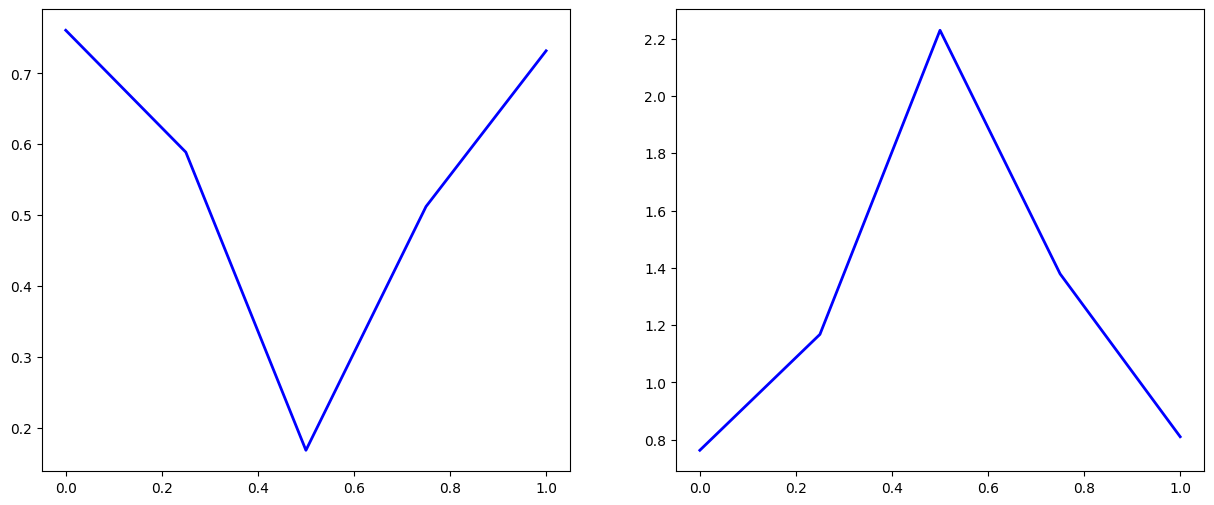

In [2]:
# Initialize a figure for plotting
from matplotlib import pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(15, 6))



# Compute the loss barrier for A-B
alphas, accs , losses = loss_barrier(model_a, model_b, test_loader)

axes[0].plot(alphas, accs, label="Acc Barrier A-B", color="blue", linewidth=2)
axes[1].plot(alphas, losses, label="Loss Barrier A-B", color="blue", linewidth=2)

for _ in range(2):
    permutation, heads_permutation = weight_matching( 
        permutation_spec,
        max_iter=100,
        fixed=model_b.net.state_dict(),
        permutee=model_a.net.state_dict(),
        num_heads=model_a.net.vit.encoder.config.num_attention_heads,
        intra_head=True,
        p_trim=None,
        normalize_weights=False,
        layer_iteration_order= LayerIterationOrder.RANDOM
    )
    perm_model_a = deepcopy(model_a)
    perm_state_dict = apply_permutation_to_statedict(permutation_spec, permutation, model_a.net.state_dict(), heads_permutation=heads_permutation)
    perm_model_a.net.load_state_dict(perm_state_dict)
    
    # Compute the loss barrier for permA-B
    alphas, perm_accs, perm_losses = loss_barrier(perm_model_a, model_b, test_loader)
    
    axes[0].plot(alphas, perm_accs, label="Acc Barrier PA-B", linestyle="--", alpha=0.7)
    axes[1].plot(alphas, perm_losses, label="Loss Barrier PA-B", linestyle="--", alpha=0.7)
    
# Add plot details 
axes[1].set_title("Loss barriers")
axes[0].set_title("Accuracy barriers")
axes[1].set_xlabel("Alpha")
axes[0].set_xlabel("Alpha")
axes[0].set_ylabel("Accs")
axes[1].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend()
axes[1].grid(True)
axes[1].legend()
plt.savefig("loss_acc_barriers-vit-b-16.png", dpi=300, bbox_inches="tight")
plt.show()